Project based on this kaggle threat: https://www.kaggle.com/code/matthewjansen/transfer-learning-skin-cancer-classification#3-%7C-Baseline-Model:-Convolutional-Neural-Network-(CNN)

## 0- Importing modules

In [1]:
!pip install -q vit-keras
!pip install tensorflow-addons
!pip install --upgrade tensorflow==2.13   #if we don't downgrade TF it will crash with Keras modules when using ViTs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 9.4 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.3.0
    Uninstalling typeguard-4.3.0:
      Successfully uninstalled typeguard-4.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.4.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 15.4 MB/s eta 0:00:00
  Attempting un

In [1]:
#PICK SESSION GOALS

#choose between training and loading the models
train_load = 'load' #'train'

#make predictions after model training/loading?
predict = False

In [2]:
# @title
!pip install scikit-plot

  Using cached scikit_plot-0.3.7-py3-none-any.whl.metadata (7.1 kB)
Using cached scikit_plot-0.3.7-py3-none-any.whl (33 kB)


In [3]:
# @title
#basic libraries
import random
import os
import glob
import time

#data handling and viz
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#tensorflow and keras
import tensorflow as tf
import tensorflow_hub as hub
import keras
from tensorflow.keras import layers, Sequential
from tensorflow.keras.utils import plot_model

#stats for model evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_fscore_support
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [4]:
# @title
# default settings
class CFG:
    EPOCHS = 10
    BATCH_SIZE = 32
    SEED = 42
    TF_SEED = 768
    HEIGHT = 224
    WIDTH = 224
    CHANNELS = 3
    IMAGE_SIZE = (224, 224, 3)
    METRICS = ['accuracy']

## 1- Inspecting datasets

In [5]:
# @title
# Define paths
from google.colab import drive
drive.mount('/content/drive')


DATASET_PATH = "/content/drive/My Drive/Wounds CV/Practice/Man or Woman classifier/data/"
TRAIN_PATH = os.path.join(DATASET_PATH, 'train/')
TEST_PATH = os.path.join(DATASET_PATH, 'test/')

# Generate a summary of the dataset
print('DATASET SUMMARY')
print('========================\n')
for dirpath, dirnames, filenames in os.walk(DATASET_PATH):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")
print('\n========================')

Mounted at /content/drive
DATASET SUMMARY

There are 2 directories and 0 images in /content/drive/My Drive/Wounds CV/Practice/Man or Woman classifier/data/
There are 2 directories and 0 images in /content/drive/My Drive/Wounds CV/Practice/Man or Woman classifier/data/test
There are 0 directories and 14 images in /content/drive/My Drive/Wounds CV/Practice/Man or Woman classifier/data/test/Woman
There are 0 directories and 14 images in /content/drive/My Drive/Wounds CV/Practice/Man or Woman classifier/data/test/Man
There are 2 directories and 0 images in /content/drive/My Drive/Wounds CV/Practice/Man or Woman classifier/data/train
There are 0 directories and 158 images in /content/drive/My Drive/Wounds CV/Practice/Man or Woman classifier/data/train/Man
There are 0 directories and 231 images in /content/drive/My Drive/Wounds CV/Practice/Man or Woman classifier/data/train/Woman



In [6]:
# @title
# Get image paths with glob
%%time
train_images = glob.glob(f"{TRAIN_PATH}/**/*.jpeg", recursive=True)
train_images.extend(glob.glob(f"{TRAIN_PATH}/**/*.jpg", recursive=True))  # Add .jpg files
train_images.extend(glob.glob(f"{TRAIN_PATH}/**/*.png", recursive=True))  # Add .png files

test_images = glob.glob(f"{TEST_PATH}/**/*.jpeg", recursive=True)
test_images.extend(glob.glob(f"{TEST_PATH}/**/*.jpg", recursive=True))  # Add .jpg files
test_images.extend(glob.glob(f"{TEST_PATH}/**/*.png", recursive=True))  # Add .png files

CPU times: user 10.5 ms, sys: 4.79 ms, total: 15.3 ms
Wall time: 80 ms


In [7]:
# @title
# Get train & test set sizes
train_size = len(train_images)
test_size = len(test_images)

# Get dataset size
total = train_size + test_size

# View samples counts
print(f'train samples count:\t\t{train_size}')
print(f'test samples count:\t\t{test_size}')
print('=======================================')
print(f'TOTAL:\t\t\t\t{total}')

train samples count:		389
test samples count:		28
TOTAL:				417


In [8]:
# @title
# Create Pandas DataFrames for paths and labels
def generate_labels(image_paths):
  return [_.split('/')[-2:][0] for _ in image_paths]

def build_df(image_paths, labels):
  # Create dataframe
  df = pd.DataFrame({
      'image_path':image_paths,
      'label':generate_labels(labels)
  })

  #Generate label encodings
  df['label_encoded'] = df.apply(lambda row: 0 if row.label == 'Man' else 1, axis=1)

  #Shuffle and return df
  return df.sample(frac=1, random_state=CFG.SEED).reset_index(drop=True)

In [9]:
# @title
# Build the DataFrames
train_df = build_df(train_images, generate_labels(train_images))
test_df = build_df(test_images, generate_labels(test_images))

In [10]:
# @title
# View first 5 samples in the trainins set
train_df.head(5)

,image_path,label,label_encoded
0,/content/drive/My Drive/Wounds CV/Practice/Man...,Woman,1
1,/content/drive/My Drive/Wounds CV/Practice/Man...,Woman,1
2,/content/drive/My Drive/Wounds CV/Practice/Man...,Man,0
3,/content/drive/My Drive/Wounds CV/Practice/Man...,Woman,1
4,/content/drive/My Drive/Wounds CV/Practice/Man...,Woman,1


In [11]:
# @title
# Load & View Random Sample Image
def _load(image_path):
    # Read and decode an image file to a uint8 tensor
    image = tf.io.read_file(image_path)

    try:
      image = tf.io.decode_jpeg(image, channels=3)

    except:
      try:
        image = tf.io.decode_png(image, channels=3)

      except:
        raise ValueError(f"Unsupported image format: {image_path}")


    # Resize image
    image = tf.image.resize(image, [CFG.HEIGHT, CFG.WIDTH], method=tf.image.ResizeMethod.LANCZOS3)

    # Convert image dtype to float32 and normalize
    image = tf.cast(image, tf.float32) / 255.0

    # Return image
    return image



def view_sample(image, label, color_map='rgb', fig_size=(4,5)):
  plt.figure(figsize=fig_size)

  if color_map=='rgb':
    plt.imshow(image)
  else:
    plt.imshow(tf.image.rgb_to_grayscale(image), cmap=color_map)

    plt.title(f'Label: {label}', fontsize=16)
    return

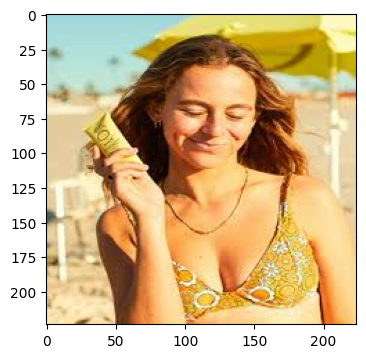

In [12]:
# @title
# Select random sample from train_df
idx = random.sample(train_df.index.to_list(),1)[0]

# Load the random sample and label
sample_image, sample_label = _load(train_df.image_path[idx]), train_df.label[idx]

# View the random sample
view_sample(sample_image, sample_label) #, color_map = 'inferno')     #for higher contrast

In [13]:
# @title
# View multiple random sample

def view_multiple_samples(df, sample_loader, count=10, color_map='rgb', fig_size=(14,10)):
  rows = count//5
  if count%5 > 0:
    rows +=1

  idx = random.sample(df.index.to_list(), count)
  fig = plt.figure(figsize=fig_size)

  for column, _ in enumerate(idx):
    plt.subplot(rows, 5, column+1)
    plt.title(f'Label: {df.label[_]}')

    if color_map=='rgb':
      plt.imshow(sample_loader(df.image_path[_]))
    else:
      plt.imshow(tf.image.rgb_to_grayscale(sample_loader(df.image_path[_])), cmap=color_map)

  return

view_multiple_samples(train_df, _load, count=25, fig_size=(20,24)) #, color_map='inferno')    #for higher contrast

Output hidden; open in https://colab.research.google.com to view.

<ipython-input-14-16f9cb1b273f>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=train_distribution.values,
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
<ipython-input-14-16f9cb1b273f>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be remov

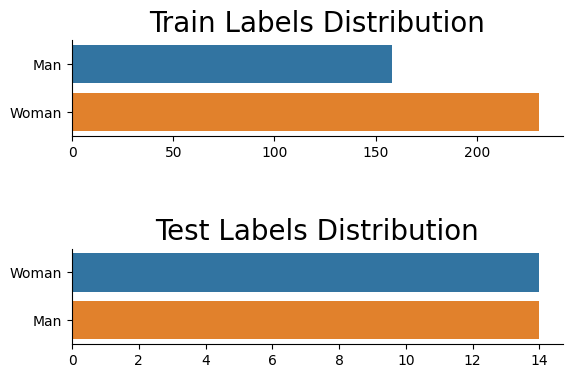

In [14]:
# @title
# View Train Labels Distribution
fig, (ax1, ax2) = plt.subplots(2, figsize=(7, 5))

# Set the spacing between subplots
fig.tight_layout(pad=6.0)

# Plot Train Labels Distribution
ax1.set_title('Train Labels Distribution', fontsize=20)
train_distribution = train_df['label'].value_counts().sort_values()
sns.barplot(x=train_distribution.values,
            y=list(train_distribution.keys()),
            palette= ['#1f77b4', '#ff7f0e'],
            orient="h",
            ax=ax1)

# Plot Test Labels Distribution
ax2.set_title('Test Labels Distribution', fontsize=20)
test_distribution = test_df['label'].value_counts().sort_values()
sns.barplot(x=test_distribution.values,
            y=list(test_distribution.keys()),
            palette= ['#1f77b4', '#ff7f0e'],
            orient="h",
            ax=ax2);

sns.despine();

## 2- Preprocessing: building an input data pipeline
- Use of TensorFlow's tf.data API instead of ImageDataGenerator
- Training data will be batched and prefetched for better training time
- Manually construct a data augmentation layer

In [15]:
# @title
# Create train and validation splits
train_split_idx, val_split_idx, _, _ = train_test_split(train_df.index,
                                                        train_df.label_encoded,
                                                        test_size=0.15,
                                                        stratify=train_df.label_encoded,
                                                        random_state=CFG.SEED)

In [16]:
# @title
# Get new training data and validation data
train_new_df = train_df.iloc[train_split_idx].reset_index(drop=True)
val_df = train_df.iloc[val_split_idx].reset_index(drop=True)

# View shapes
train_new_df.shape, val_df.shape

((330, 3), (59, 3))

<ipython-input-17-a88305860f7c>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=train_new_distribution.values,
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
<ipython-input-17-a88305860f7c>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be r

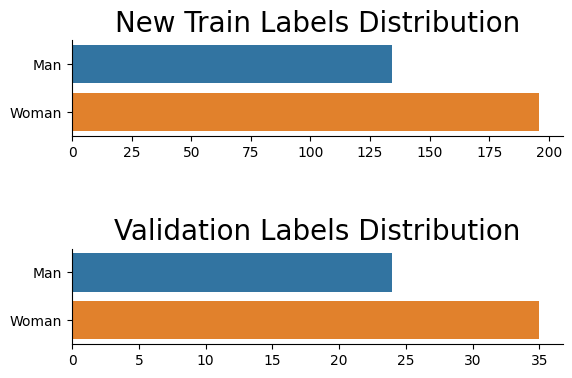

In [17]:
# @title
# View new Train & Validation labels distribution
fig, (ax1, ax2) = plt.subplots(2, figsize=(7,5))

# Set the spacing between subplots
fig.tight_layout(pad=6.0)

# Plot New Train Labels Distribution
ax1.set_title('New Train Labels Distribution', fontsize=20)
train_new_distribution = train_new_df['label'].value_counts().sort_values()
sns.barplot(x=train_new_distribution.values,
            y=list(train_new_distribution.keys()),
            palette= ['#1f77b4', '#ff7f0e'],
            orient="h",
            ax=ax1)

# Plot Validation Labels Distribution
ax2.set_title('Validation Labels Distribution', fontsize=20)
val_distribution = val_df['label'].value_counts().sort_values()
sns.barplot(x=val_distribution.values,
            y=list(val_distribution.keys()),
            palette= ['#1f77b4', '#ff7f0e'],
            orient="h",
            ax=ax2);

sns.despine();

In [18]:
# @title
# Create an Image Data Augmentation Layer
augmentation_layer = Sequential([
    layers.RandomFlip(mode='horizontal_and_vertical', seed=CFG.TF_SEED),
    layers.RandomZoom(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1),
                      seed=CFG.TF_SEED)
    # ,layers.RandomRotation(factor=0.2, seed=CFG.TF_SEED)       #addition
    # ,layers.RandomTranslation(height_factor=0.1, width_factor=0.1, seed=CFG.TF_SEED)       #addition
    # ,layers.RandomContrast(factor=0.2, seed=CFG.TF_SEED)       #addition
    # ,layers.RandomBrightness(factor=0.9, seed=CFG.TF_SEED)       #addition  THIS IS BROKEN
    # ,layers.RandomCrop(height=CFG.HEIGHT, width=CFG.WIDTH, seed=CFG.TF_SEED)       #addition
    # ,layers.GaussianNoise(stddev=0.1, seed=CFG.TF_SEED)       #addition

], name='augmentation_layer')

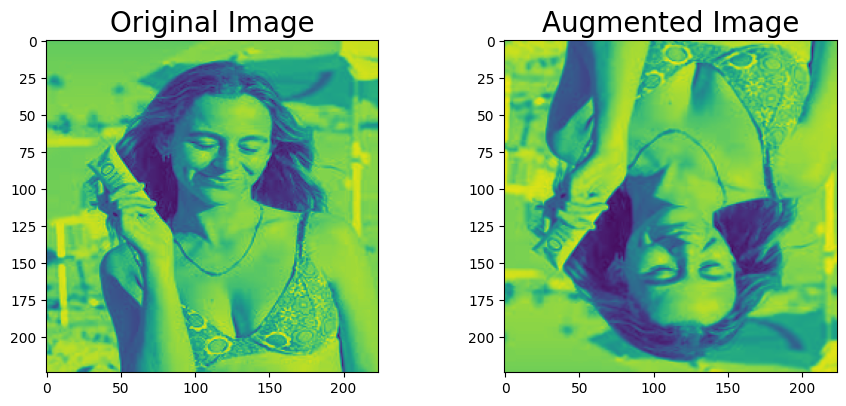

In [19]:
# @title
image = tf.image.rgb_to_grayscale(sample_image)
# image = sample_image

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,7))

# Set the spacing between subplots
fig.tight_layout(pad=6.0)

# View Original Image
ax1.set_title('Original Image', fontsize=20)
ax1.imshow(image)

# View Augmented Image
ax2.set_title('Augmented Image', fontsize=20)
ax2.imshow(augmentation_layer(image))

In [20]:
# @title
# Create input data pipeline with tf.data API
def encode_labels(labels, encode_depth=2):
    return tf.one_hot(labels, depth=encode_depth).numpy()

def create_pipeline(df, load_function, augment=False, batch_size=32, shuffle=False, cache=None, prefetch=False):
    # Get image paths and labels from DataFrame
    image_paths = df.image_path
    image_labels = encode_labels(df.label_encoded)
    AUTOTUNE = tf.data.AUTOTUNE

    # Create dataset with raw data from DataFrame
    ds = tf.data.Dataset.from_tensor_slices((image_paths, image_labels))

    # Map augmentation layer and load function to dataset inputs if augment is True
    # Else map only the load function
    if augment:
        ds = ds.map(lambda x, y: (augmentation_layer(load_function(x)), y), num_parallel_calls=AUTOTUNE)
    else:
        ds = ds.map(lambda x, y: (load_function(x), y), num_parallel_calls=AUTOTUNE)

    # Apply shuffling based on condition
    if shuffle:
        ds = ds.shuffle(buffer_size=1000)

    # Apply batching
    ds = ds.batch(batch_size)

    # Apply caching based on condition
    # Note: Use cache in memory (cache='') if the data is small enough to fit in memory!!!
    if cache != None:
        ds = ds.cache(cache)

    # Apply prefetching based on condition
    # Note: This will result in memory trade-offs
    if prefetch:
        ds = ds.prefetch(buffer_size=AUTOTUNE)

    # Return the dataset
    return ds

In [21]:
# @title
# Generate Train Input Pipeline
train_ds = create_pipeline(train_new_df, _load, augment=True,
                           batch_size=CFG.BATCH_SIZE,
                           shuffle=False, prefetch=True)

# Generate Validation Input Pipeline
val_ds = create_pipeline(val_df, _load,
                         batch_size=CFG.BATCH_SIZE,
                         shuffle=False, prefetch=False)

# Generate Test Input Pipeline
test_ds = create_pipeline(test_df, _load,
                          batch_size=CFG.BATCH_SIZE,
                          shuffle=False, prefetch=False)

In [22]:
# @title
# View string representation of datasets
print('========================================\n')
print('Train Input Data Pipeline:\n\n', train_ds)
print('========================================\n')
print('Validation Input Data Pipeline:\n\n', val_ds)
print('========================================\n')
print('Test Input Data Pipeline:\n\n', test_ds)
print('========================================\n')


Train Input Data Pipeline:

 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>

Validation Input Data Pipeline:

 <_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>

Test Input Data Pipeline:

 <_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>



## 3- Baseline Model: Convolutional Neural Network (CNN)

In [23]:
# DEFINE CNN MODEL
def cnn_model():
  initializer = tf.keras.initializers.GlorotNormal()

  cnn_sequential = Sequential([
      layers.Input(shape=CFG.IMAGE_SIZE, dtype=tf.float32, name='input_image'),

      layers.Conv2D(16, kernel_size=3, activation='relu', kernel_initializer=initializer),
      layers.Conv2D(16, kernel_size=3, activation='relu', kernel_initializer=initializer),
      layers.MaxPool2D(pool_size=2, padding='valid'),

      layers.Conv2D(8, kernel_size=7, activation='relu', kernel_initializer=initializer),
      layers.Conv2D(8, kernel_size=7, activation='relu', kernel_initializer=initializer),
      layers.MaxPool2D(pool_size=2),

      layers.Flatten(),
      layers.Dropout(0.2),
      layers.Dense(128, activation='relu', kernel_initializer=initializer),
      layers.Dense(2, activation='sigmoid', kernel_initializer=initializer)
  ], name='cnn_sequential_model')

  return cnn_sequential

In [24]:
# GENERATE MODEL
model_cnn = cnn_model()

# GENERATE SUMMARY OF THE MODEL
model_cnn.summary()

Model: "cnn_sequential_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2  (None, 110, 110, 16)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 104, 104, 8)       6280      
                                                                 


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


 conv2d_3 (Conv2D)           (None, 98, 98, 8)         3144      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 49, 49, 8)         0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 19208)             0         
                                                                 
 dropout (Dropout)           (None, 19208)             0         
                                                                 
 dense (Dense)               (None, 128)               2458752   
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 2471202 (9.43 MB)
Trainable params: 2471202 (9.43 MB)
Non-trainable params: 0 (0.00 Byte)
______________________________________

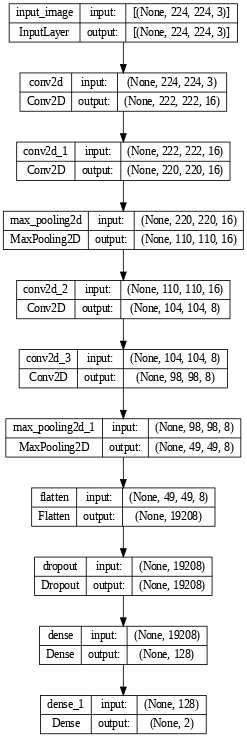

In [25]:
# EXPLORE MODEL VISUALLY
plot_model(
    model_cnn, dpi=60,
    show_shapes=True
)

In [26]:
# TRAIN CNN MODEL
  # - We'll use "binary crossentropy" as the loss function since this is a classification problem for binary labels
  # - We'll use the Adam optimizer with 0.001 as the (default) learning rate
  # - We'll use TensorFlow's Callback API to implement EarlyStopping & ReduceLROnPlateau to prevent overfitting

def train_model(model, num_epochs, callbacks_list, tf_train_data,
                tf_valid_data=None, shuffling=False):

  model_history = {}

  if tf_valid_data != None:
    model_history = model.fit(tf_train_data,
                              epochs=num_epochs,
                              validation_data=tf_valid_data,
                              # validation_steps=int(len(tf_valid_data)),   #crashes the training as validation data empties after the first epoch. Worked at the beginning but stoped working after a Tensorflow update in July 2024.
                              callbacks=callbacks_list,
                              shuffle=shuffling)

  if tf_valid_data == None:
    model_history = model.fit(tf_train_data,
                              epochs=num_epochs,
                              callbacks=callbacks_list,
                              shuffle=shuffling)
  return model_history

In [27]:
# Define Early Stopping Callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Define Reduce Learning Rate Callback
reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor = 'val_loss',
    patience=2,
    factor=0.1,
    verbose=1
)

# Define Callbacks and Metrics lists
CALLBACKS =[reduce_lr_callback] #early_stopping_callback]



---



---



In [28]:
#TRAINING THE MODEL

if train_load == 'train':
  tf.random.set_seed(CFG.SEED)

  # COMPILE THE MODEL
  model_cnn.compile(
      loss=tf.keras.losses.BinaryCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
      metrics=CFG.METRICS
  )

  # TRAIN THE MODEL
  print(f'Training {model_cnn.name}.')
  print(f'Train on {len(train_new_df)} samples, validate on {len(val_df)} samples.')
  print('----------------------------------')

  EPOCHS = 20 #setting it to 20 as we've proved that this is optimal for this model

  cnn_history = train_model(
      model_cnn, EPOCHS, CALLBACKS,
      train_ds, val_ds,
      shuffling=False
  )

In [29]:
# SAVE MODEL IN LOCAL

if train_load == 'train':
  #save model
  model_cnn.save('/content/drive/My Drive/Wounds CV/Practice/Man or Woman classifier/trained_models/model_cnn.h5')
  model_cnn.save('/content/drive/My Drive/Wounds CV/Practice/Man or Woman classifier/trained_models/model_cnn.keras')

  #save training history
  import pickle
  with open('/content/drive/My Drive/Wounds CV/Practice/Man or Woman classifier/trained_models/model_cnn_history.pkl', 'wb') as file:
      pickle.dump(cnn_history.history, file)

In [30]:
if train_load == 'load':
  model_cnn = keras.models.load_model('/content/drive/My Drive/Wounds CV/Practice/Man or Woman classifier/trained_models/model_cnn/model_cnn_opt')
  model_cnn.summary()

Model: "cnn_sequential_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2  (None, 110, 110, 16)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 104, 104, 8)       6280      
                                                                 
 conv2d_3 (Conv2D)           (None, 98, 98, 8)         3144      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 49, 49, 8)         0         
 g2D)                                         

In [31]:
# EVALUATE THE MODEL
cnn_evaluation = model_cnn.evaluate(test_ds)

1/1 [==============================] - 10s 10s/step - loss: 0.7229 - accuracy: 0.6429


In [32]:
# GENERATE MODEL PROBABILITIES  AND ASSOCIATED PREDICTIONS
cnn_test_probabilities = model_cnn.predict(test_ds, verbose=1)
cnn_test_predictions = tf.argmax(cnn_test_probabilities, axis=1)

1/1 [==============================] - 2s 2s/step


In [33]:
from google.colab import files
from PIL import Image
import io

class_labels = {0: 'MAN', 1: 'WOMAN'}

def predict_upload(uploaded, model):
  #print image
  file_name = next(iter(uploaded))
  image = Image.open(io.BytesIO(uploaded[file_name]))
  plt.imshow(image)
  plt.axis('off')
  plt.show()

  #preprocess image
  image = image.resize((CFG.WIDTH, CFG.HEIGHT))
  image = np.array(image) / 255.0  # Normalize the image to [0, 1]
  image = np.expand_dims(image, axis=0)  # Add batch dimension
  image = tf.convert_to_tensor(image, dtype=tf.float32)

  # Make predictions
  predictions = model.predict(image)


  # Assuming your model outputs probabilities for each class
  predicted_probabilities = predictions[0]  # Assuming batch size is 1
  predicted_class_index = np.argmax(predicted_probabilities)  # Get the predicted class index
  predicted_probability = predicted_probabilities[predicted_class_index]  # Get the predicted probability

  # Get the predicted label name
  predicted_label_name = class_labels[predicted_class_index]

  # Print the predicted label name and probability
  print(f"Predicted label: {predicted_label_name}")
  print(f"Predicted probability: {predicted_probability:.4f}")
  print(predictions)


  #predict image
  cnn_test_probabilities = model.predict(image, verbose=1)
  cnn_test_predictions = tf.argmax(cnn_test_probabilities, axis=1).numpy()
  prob = int(max(max(cnn_test_probabilities))*100)
  predicted_label = class_labels[cnn_test_predictions[0]]

In [34]:
if predict == True:
  #load image
  uploaded = files.upload()

  #make predictions
  predict_upload(uploaded, model_cnn)



---


---




## 4- Transfer Learning Model: EfficientNet V2 B0
EfficientNetV2 is a convolutional neural network that has faster training speed and better parameter efficiency than previous EfficientNetV1 models.

In [35]:
# getting any model from tensorflow hub
def get_tfhub_model(model_link, model_name, model_trainable=False):
  return hub.KerasLayer(model_link,
                        trainable = model_trainable,
                        name = model_name)

In [36]:
# @title
# getting EfficientNet from TensorFlow Hub
efficientnet_v2_url = 'https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b0/feature_vector/2'
model_name = 'efficientnet_v2_b0'

# trainable = False, for inference-only
set_trainable=False

efficientnet_v2_b0 = get_tfhub_model(efficientnet_v2_url,
                                     model_name,
                                     model_trainable = set_trainable)

In [37]:
# # define EfficientNet Model
# def efficientnet_v2_model():

#     initializer = tf.keras.initializers.GlorotNormal()

#     efficientnet_v2_sequential = Sequential([
#         layers.Input(shape=CFG.IMAGE_SIZE, dtype=tf.float32, name='input_image'),
#         efficientnet_v2_b0,
#         layers.Dropout(0.2),
#         layers.Dense(128, activation='relu', kernel_initializer=initializer),
#         layers.Dense(2, dtype=tf.float32, activation='sigmoid', kernel_initializer=initializer)
#     ], name='efficientnet_v2_sequential_model')

#     return efficientnet_v2_sequential

In [38]:
# WORKAROUND 2 (previous didn't work)

def efficientnet_v2_model():
    initializer = tf.keras.initializers.GlorotNormal()

    # Define Sequential Model
    efficientnet_v2_sequential = Sequential([
        layers.Input(shape=CFG.IMAGE_SIZE, dtype=tf.float32, name='input_image'),
        layers.Lambda(lambda x: efficientnet_v2_b0(x)),       # original code didn't have this, but it ran into an error "ValueError: Only instances of keras.Layer can be added to a Sequential model. Received: <tensorflow_hub.keras_layer.KerasLayer object at 0x7c52ec21c970> (of type <class 'tensorflow_hub.keras_layer.KerasLayer'>)"

        layers.Dropout(0.2),
        layers.Dense(128, activation='relu', kernel_initializer=initializer),
        layers.Dense(2, activation='sigmoid', kernel_initializer=initializer)
    ], name='efficientnet_v2_sequential_model')

    return efficientnet_v2_sequential


In [39]:
# Generate Model
model_efficientnet_v2 = efficientnet_v2_model()

# Generate Summary of the Model
model_efficientnet_v2.summary()

The following Variables were used a Lambda layer's call (lambda), but
are not present in its tracked objects:
  <tf.Variable 'efficientnetv2-b0/blocks_20/tpu_batch_normalization_2/beta:0' shape=(192,) dtype=float32>
  <tf.Variable 'efficientnetv2-b0/blocks_20/tpu_batch_normalization_2/gamma:0' shape=(192,) dtype=float32>
  <tf.Variable 'efficientnetv2-b0/blocks_20/conv2d_1/kernel:0' shape=(1, 1, 1152, 192) dtype=float32>
  <tf.Variable 'efficientnetv2-b0/blocks_20/se/conv2d_1/bias:0' shape=(1152,) dtype=float32>
  <tf.Variable 'efficientnetv2-b0/blocks_20/se/conv2d_1/kernel:0' shape=(1, 1, 48, 1152) dtype=float32>
  <tf.Variable 'efficientnetv2-b0/blocks_20/se/conv2d/bias:0' shape=(48,) dtype=float32>
  <tf.Variable 'efficientnetv2-b0/blocks_20/se/conv2d/kernel:0' shape=(1, 1, 1152, 48) dtype=float32>
  <tf.Variable 'efficientnetv2-b0/blocks_20/tpu_batch_normalization_1/beta:0' shape=(1152,) dtype=float32>
  <tf.Variable 'efficientnetv2-b0/blocks_20/tpu_batch_normalization_1/gamma:0' s

Model: "efficientnet_v2_sequential_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 1280)              0         
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               163968    
                                                                 
 dense_3 (Dense)             (None, 2)                 258       
                                                                 
Total params: 164226 (641.51 KB)
Trainable params: 164226 (641.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


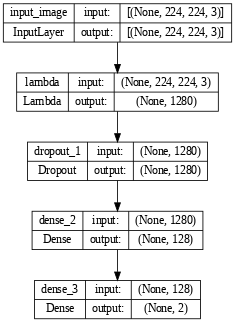

In [40]:
plot_model(
    model_efficientnet_v2, dpi=60, show_shapes=True
)

In [41]:
# Train EfficientNet Model

if train_load == 'train':
  CALLBACKS = [early_stopping_callback, reduce_lr_callback]
  tf.random.set_seed(CFG.SEED)

  #compile model
  model_efficientnet_v2.compile(
      loss=tf.keras.losses.BinaryCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
      metrics=CFG.METRICS
  )

  #train model
  print(f'Training {model_efficientnet_v2.name}.')
  print(f'Train on {len(train_new_df)} samples, validate on {len(val_df)} samples.')
  print('------------------------------')

  efficientnet_v2_history = train_model(
      model_efficientnet_v2, CFG.EPOCHS, CALLBACKS, train_ds, val_ds, shuffling=False
  )

In [42]:
# SAVE MODEL IN LOCAL

if train_load == 'train':
  #save model
  model_efficientnet_v2.save('/content/drive/My Drive/Wounds CV/Practice/Man or Woman classifier/trained_models/model_efficientnet_v2.h5')
  model_efficientnet_v2.save('/content/drive/My Drive/Wounds CV/Practice/Man or Woman classifier/trained_models/model_efficientnet_v2.keras')

  #save training history
  import pickle
  with open('/content/drive/My Drive/Wounds CV/Practice/Man or Woman classifier/trained_models/model_efficientnet_v2_history.pkl', 'wb') as file:
      pickle.dump(efficientnet_v2_history.history, file)

In [43]:
if train_load == 'load':
  save_path = '/content/drive/My Drive/Wounds CV/Practice/Man or Woman classifier/trained_models/model_efficientnet_v2/model_efficientnet_v2.keras'
  model_efficientnet_v2 = keras.saving.load_model(save_path, safe_mode=False) #, compile=True)
  model_efficientnet_v2.summary()

The following Variables were used a Lambda layer's call (lambda), but
are not present in its tracked objects:
  <tf.Variable 'efficientnetv2-b0/blocks_20/tpu_batch_normalization_2/beta:0' shape=(192,) dtype=float32>
  <tf.Variable 'efficientnetv2-b0/blocks_20/tpu_batch_normalization_2/gamma:0' shape=(192,) dtype=float32>
  <tf.Variable 'efficientnetv2-b0/blocks_20/conv2d_1/kernel:0' shape=(1, 1, 1152, 192) dtype=float32>
  <tf.Variable 'efficientnetv2-b0/blocks_20/se/conv2d_1/bias:0' shape=(1152,) dtype=float32>
  <tf.Variable 'efficientnetv2-b0/blocks_20/se/conv2d_1/kernel:0' shape=(1, 1, 48, 1152) dtype=float32>
  <tf.Variable 'efficientnetv2-b0/blocks_20/se/conv2d/bias:0' shape=(48,) dtype=float32>
  <tf.Variable 'efficientnetv2-b0/blocks_20/se/conv2d/kernel:0' shape=(1, 1, 1152, 48) dtype=float32>
  <tf.Variable 'efficientnetv2-b0/blocks_20/tpu_batch_normalization_1/beta:0' shape=(1152,) dtype=float32>
  <tf.Variable 'efficientnetv2-b0/blocks_20/tpu_batch_normalization_1/gamma:0' s

Model: "efficientnet_v2_sequential_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 1280)              0         
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               163968    
                                                                 
 dense_3 (Dense)             (None, 2)                 258       
                                                                 
Total params: 164226 (641.51 KB)
Trainable params: 164226 (641.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [44]:
# evaluate the model
efficientnet_v2_evaluation = model_efficientnet_v2.evaluate(test_ds)

1/1 [==============================] - 5s 5s/step - loss: 0.1345 - accuracy: 0.9643


In [45]:
#generate model probabilities and associated predictions
efficientnet_v2_test_probabilities = model_efficientnet_v2.predict(test_ds, verbose=1)
efficientnet_v2_test_predictions = tf.argmax(efficientnet_v2_test_probabilities, axis=1)

1/1 [==============================] - 6s 6s/step


In [46]:
if predict == True:
  #load image
  uploaded = files.upload()

  #make predictions
  predict_upload(uploaded, model_efficientnet_v2)



---


---




## 5- Transfer Learning Model: Vision Transformer (ViT-B16)
With ViTs, an input image is preprocessed into patches just like in NLP text is split in word tokens. These 'patches' are used along with the transform encoder to generate image embeddings. The transformer encoder blocks consists of three components:

 1- Layer Normalization: applied to the patches and attention for computational speedup.

 2- Multi-head Attention: used to generate and concatenate attention heads for all patches to capture local and global dependencies in an image.

 3- Multi-Layer Perceptrons (MLP): takes the attention heads and passes them through two dense layers with the Gaussian Error Linear Unit (GELU) as the activation function.

<b>- Pros: </b> Vision Transformers achive remarkable results while requiring less computational resources for pre-training, compared to CNNs.

<b>- Cons: </b> ViTs generally perform worse on smaller datasets than CNNs; while better in big datasets.

In [47]:
from vit_keras import vit

#download the model
vit_model = vit.vit_b16(
    image_size=224,
    activation='sigmoid',
    pretrained=True,
    include_top=False,
    pretrained_top=False,
    classes=2
)

# Freeze model layers for inference-mode only
for layer in vit_model.layers:
  layer.trainable=False

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


347502902/347502902 [==============================] - 3s 0us/step


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


In [48]:
# Define Vision Transformer Model
def vit_b16_model():
  initializer = tf.keras.initializers.GlorotNormal()

  vit_b16_sequential = Sequential([
      layers.Input(shape=CFG.IMAGE_SIZE, dtype=tf.float32, name='input_image'),
      vit_model,
      layers.Dropout(0.2),
      layers.Dense(128, activation='relu', kernel_initializer=initializer),
      layers.Dense(2, dtype=tf.float32, activation='sigmoid', kernel_initializer=initializer)
  ], name='vit_b16_sequential_model')

  return vit_b16_sequential

In [49]:
# generate model
model_vit_b16 = vit_b16_model()

# generate summary of the model
model_vit_b16.summary()

Model: "vit_b16_sequential_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b16 (Functional)        (None, 768)               85798656  
                                                                 
 dropout_2 (Dropout)         (None, 768)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               98432     
                                                                 
 dense_5 (Dense)             (None, 2)                 258       
                                                                 
Total params: 85897346 (327.67 MB)
Trainable params: 98690 (385.51 KB)
Non-trainable params: 85798656 (327.30 MB)
_________________________________________________________________


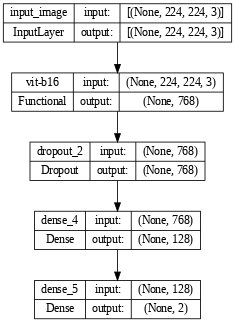

In [50]:
# explore model visually
plot_model(
    model_vit_b16, dpi=60,
    show_shapes=True
)

In [51]:
# Train Vision Transformer Model
tf.random.set_seed(CFG.SEED)

if train_load == 'train':
  #compile model
  model_vit_b16.compile(
      loss=tf.keras.losses.BinaryCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
      metrics=CFG.METRICS
  )

  #train model
  print(f'Training {model_vit_b16.name}.')
  print(f'Train on {len(train_new_df)} samples, validate on {len(val_df)} samples.')
  print('-------------------------')

  vit_b16_history = train_model(
      model_vit_b16, CFG.EPOCHS, CALLBACKS,
      train_ds, val_ds,
      shuffling=False
  )

In [52]:
# SAVE MODEL IN LOCAL

if train_load == 'train':
  #save model
  model_vit_b16.save('/content/drive/My Drive/Wounds CV/Practice/Man or Woman classifier/trained_models/model_vit_b16.keras')

  #save training history
  import pickle
  with open('/content/drive/My Drive/Wounds CV/Practice/Man or Woman classifier/trained_models/model_vit_b16_history.pkl', 'wb') as file:
      pickle.dump(vit_b16_history.history, file)

In [53]:
# LOAD MODEL

if train_load == 'load':
  save_path = '/content/drive/My Drive/Wounds CV/Practice/Man or Woman classifier/trained_models/model_vit_b16/model_vit_b16.keras'
  model_vit_b16 = keras.saving.load_model(save_path, safe_mode=False) #, compile=True)
  model_vit_b16.summary()

Model: "vit_b16_sequential_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b16 (Functional)        (None, 768)               85798656  
                                                                 
 dropout_2 (Dropout)         (None, 768)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               98432     
                                                                 
 dense_5 (Dense)             (None, 2)                 258       
                                                                 
Total params: 85897346 (327.67 MB)
Trainable params: 98690 (385.51 KB)
Non-trainable params: 85798656 (327.30 MB)
_________________________________________________________________


In [54]:
# evaluate model
vit_b16_evaluation = model_vit_b16.evaluate(test_ds)

1/1 [==============================] - 41s 41s/step - loss: 0.0904 - accuracy: 0.9286


In [55]:
#generate model probabilities and associated predictions
vit_b16_test_probabilities = model_vit_b16.predict(test_ds, verbose=1)
vit_b16_test_predictions = tf.argmax(vit_b16_test_probabilities, axis=1)

1/1 [==============================] - 38s 38s/step


In [56]:
if predict == True:
  #load image
  uploaded = files.upload()

  #make predictions
  predict_upload(uploaded, model_vit_b16)



---



---


## 6- Performance Evaluation
We'll use the following resources to evaluate on unseen test data:
  - Scikit Learn library
  - Classification Report
  - Accuracy Score
  - Precision
  - Recall
  - F1-score
  - Matthews Correlation Coefficient

### Model Histories

In [57]:
# PLOT MODEL HISTORIES
def plot_training_curves(history):

  loss = np.array(history['loss'])
  val_loss = np.array(history['val_loss'])

  accuracy = np.array(history['accuracy'])
  val_accuracy = np.array(history['val_accuracy'])

  epochs = range(len(history['loss']))

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

  #plot loss
  ax1.plot(epochs, loss, label='training_loss', marker='o')
  ax1.plot(epochs, val_loss, label='val_loss', marker='o')

  ax1.fill_between(epochs, loss, val_loss, where=(loss > val_loss), color='C0', alpha=0.3, interpolate=True)
  ax1.fill_between(epochs, loss, val_loss, where=(loss < val_loss), color='C1', alpha=0.3, interpolate=True)

  ax1.set_title('Loss (Lower Means Better)', fontsize=16)
  ax1.set_xlabel('Epochs', fontsize=12)
  ax1.legend()

  # Plot accuracy
  ax2.plot(epochs, accuracy, label='training_accuracy', marker='o')
  ax2.plot(epochs, val_accuracy, label='val_accuracy', marker='o')

  ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy > val_accuracy), color='C0', alpha=0.3, interpolate=True)
  ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy < val_accuracy), color='C1', alpha=0.3, interpolate=True)

  ax2.set_title('Accuracy (Higher Means Better)', fontsize=16)
  ax2.set_xlabel('Epochs', fontsize=12)
  ax2.legend();

In [58]:
import pickle
if train_load == 'load':
  save_path = '/content/drive/My Drive/Wounds CV/Practice/Man or Woman classifier/trained_models/model_cnn/model_cnn_history.pkl'
  with open(save_path, 'rb') as file:
      cnn_history = pickle.load(file)

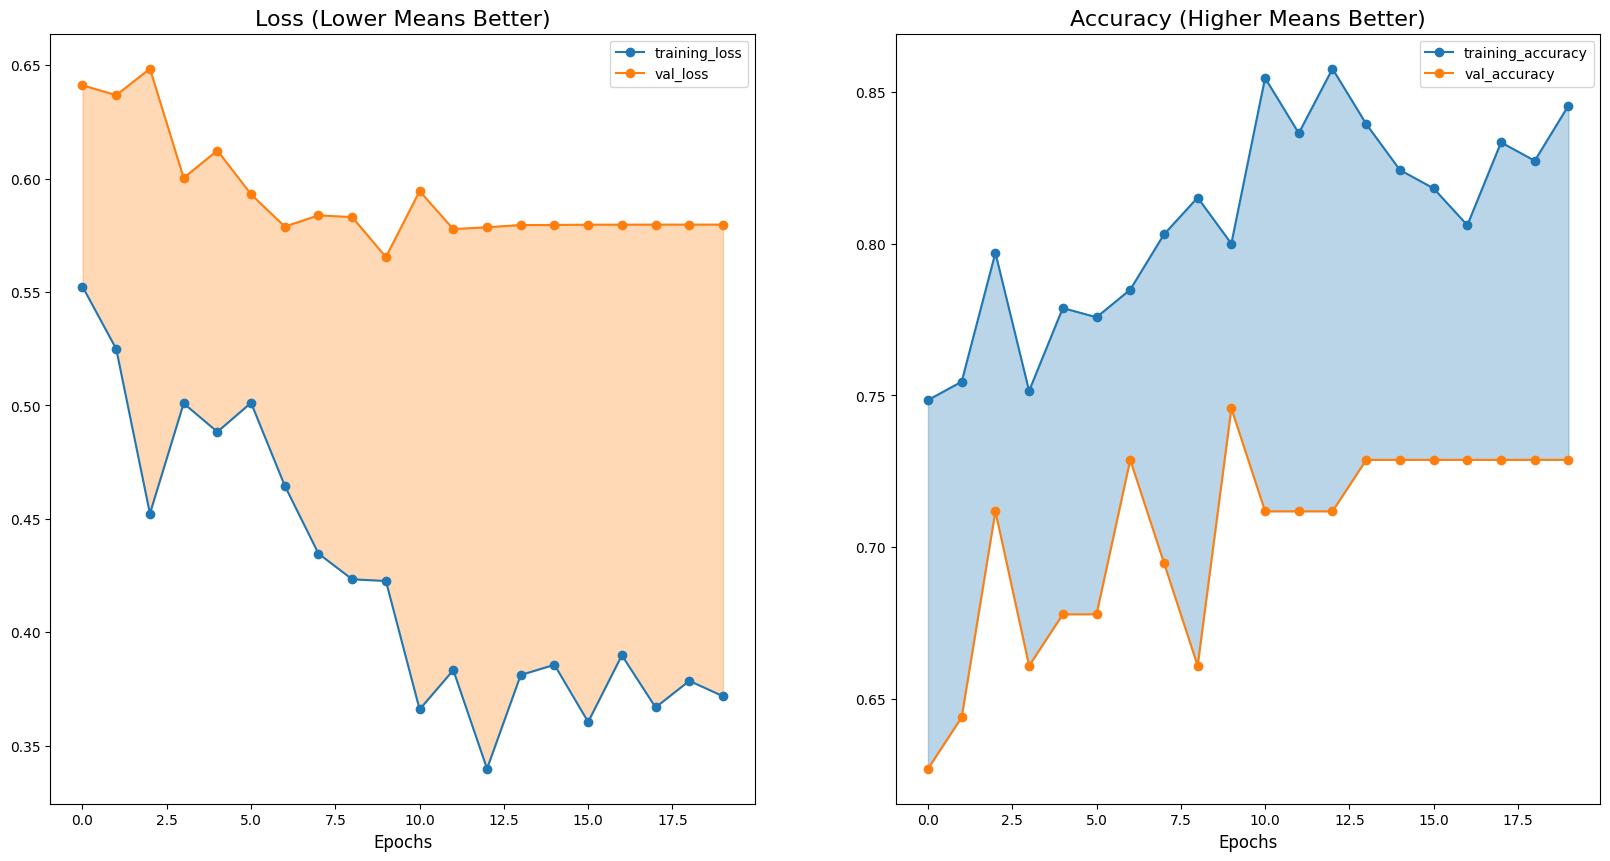

In [59]:
# plot cnn model training history
plot_training_curves(cnn_history)

<b>Insight:</b> we observe a stable convergence to a lower training loss, but the validation loss stops dropping after some epochs and gets flat. This is a clear indication of overfitting. Meanwhile, the epochs have a positive effect in the model learning from both training and validation perspectives, but the validation one never gets to the level of the training (always 15% below), which also indicates overfitting. The dataset is probably too short to learn remarkable features.

In [60]:
import pickle
if train_load == 'load':
  save_path = '/content/drive/My Drive/Wounds CV/Practice/Man or Woman classifier/trained_models/model_efficientnet_v2/model_efficientnet_v2_history.pkl'
  with open(save_path, 'rb') as file:
      efficientnet_v2_history = pickle.load(file)

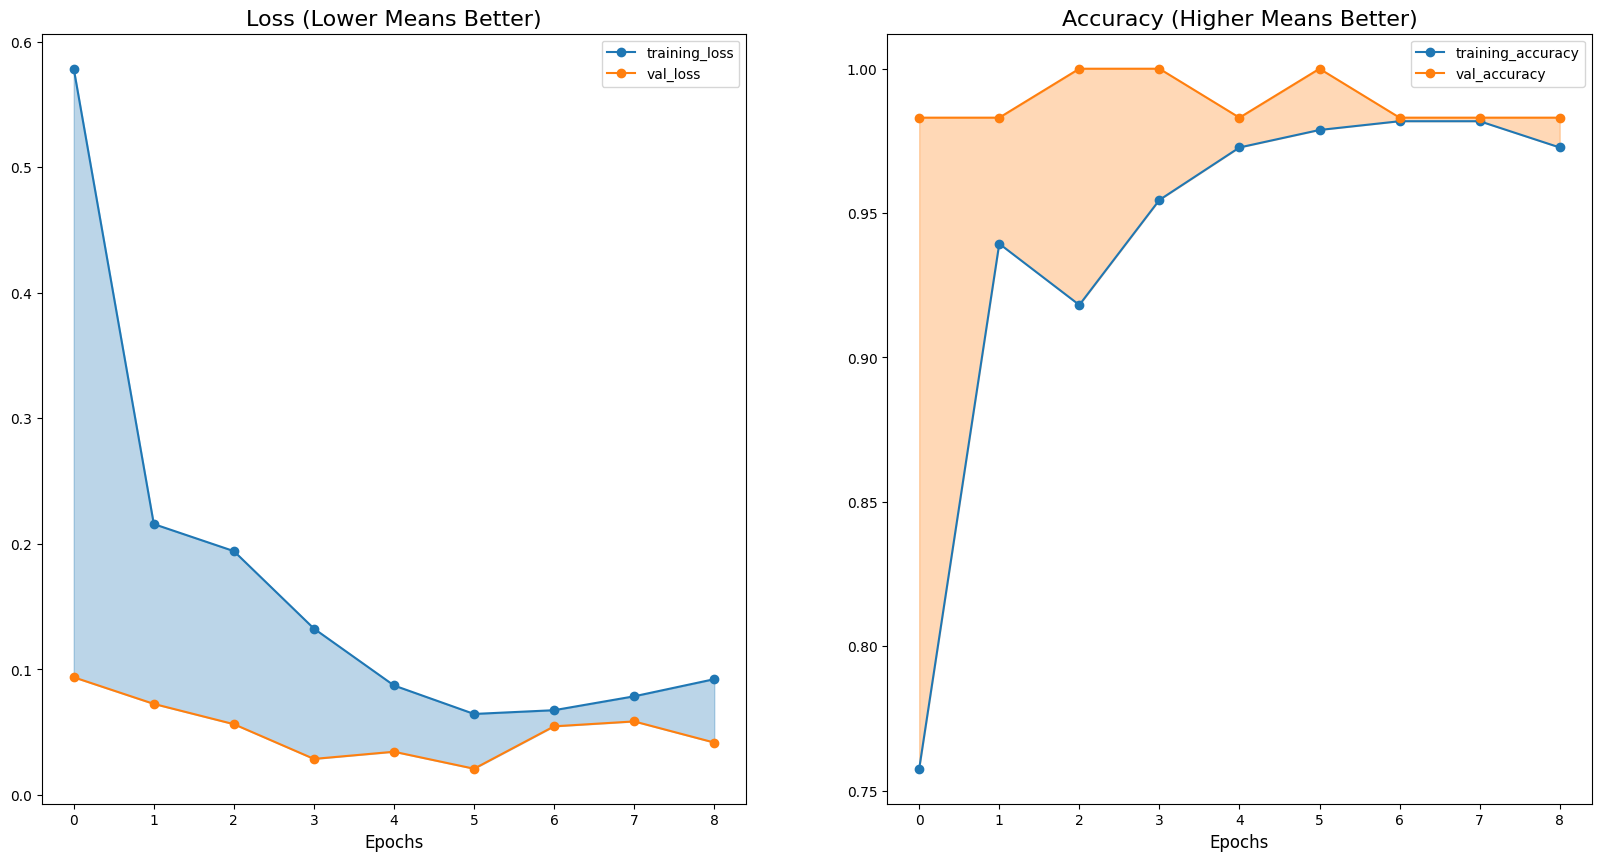

In [61]:
# Plot EfficientNet V2 B0 model training history
plot_training_curves(efficientnet_v2_history)

<b>Insight:</b> the training with Transfer Learning from another CNN like 'EfficientNet V.2' results in a much better situation for both loss and accuracy. In both cases the results converge to very optimal levels, both for training and validation. This showcases the high power of the pre-trained model, since still with the short training dataset, the model hits a high accuracy/low loss very quickly (1 or 2 epochs), which then gets even better (close to perfection).

In [62]:
import pickle

if train_load == 'load':
  save_path = '/content/drive/My Drive/Wounds CV/Practice/Man or Woman classifier/trained_models/model_vit_b16/model_vit_b16_history.pkl'
  with open(save_path, 'rb') as file:
      vit_b16_history = pickle.load(file)

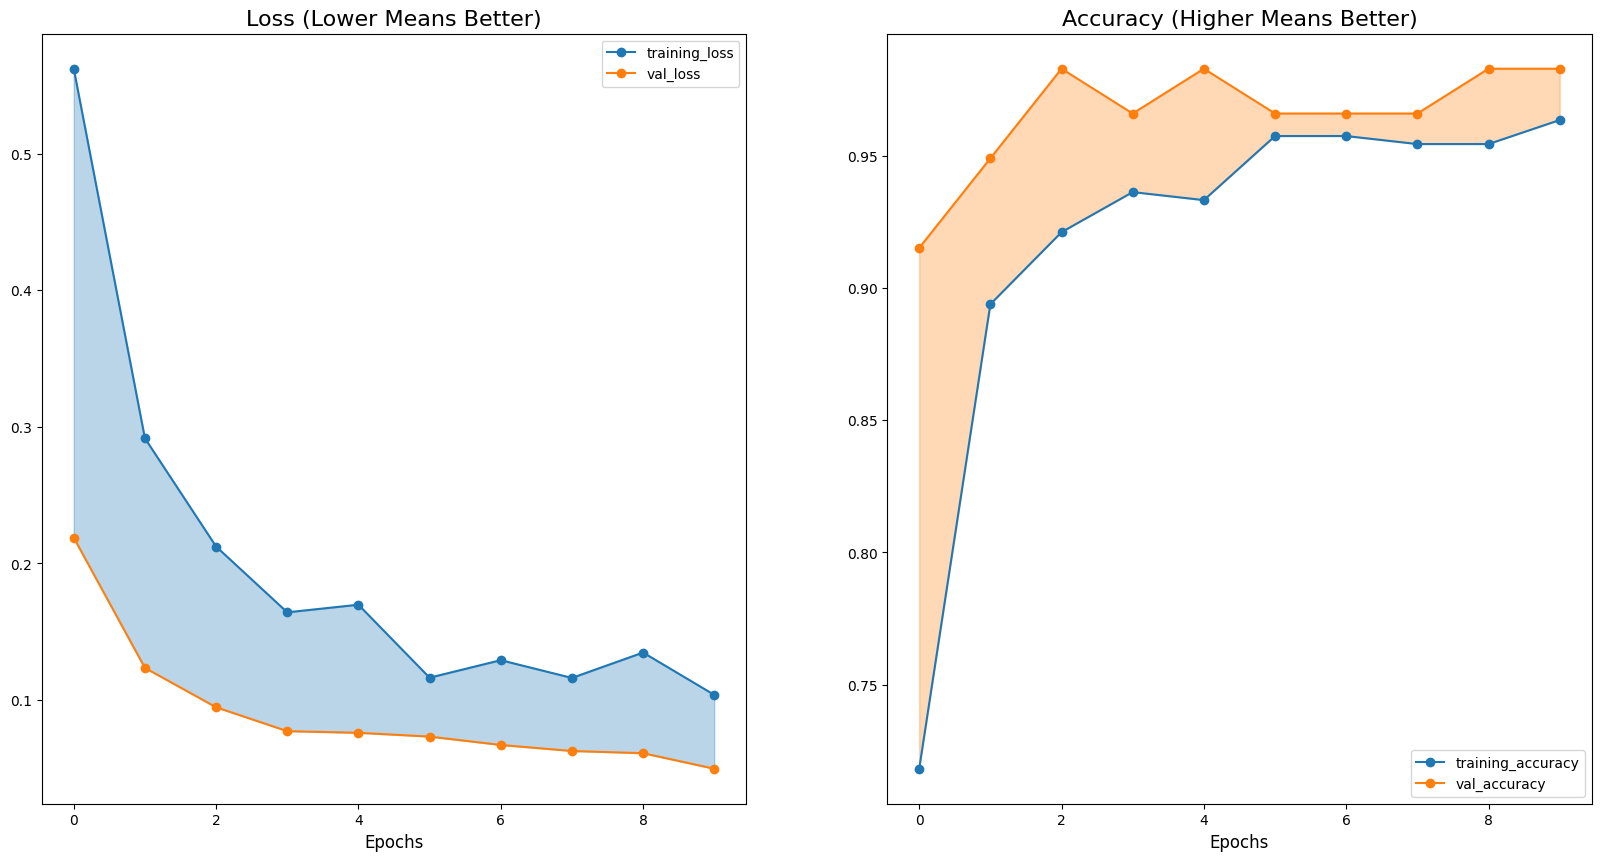

In [63]:
# Plot VIT B16 model training history
plot_training_curves(vit_b16_history)

<b>Insight:</b> finally, in the case of the Vision Transformer model the result is also notable thanks to the Transfer Learning, but it's not able to outperform the EfficientNet CNN. This highlights one characteristical difference between CNNs and ViTs: the former are stronger when a short training dataset is available; while the latter usually outperforms with large datasets. The reason is that the CNNs focus more on details and specific traits of images; while the latter learns more generally and conceptually about pictures, which demands a higher sample of images.

### Confusion Matrixes

In [64]:
# PLOT CONFUSION MATRIX
def plot_confusion_matrix(y_true, y_pred, classes='auto', figsize=(10, 10), text_size=12):
    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Set plot size
    plt.figure(figsize=figsize)

    # Create confusion matrix heatmap
    disp = sns.heatmap(
        cm, annot=True, cmap='Greens',
        annot_kws={"size": text_size}, fmt='g',
        linewidths=1, linecolor='black', clip_on=False,
        xticklabels=classes, yticklabels=classes)

    # Set title and axis labels
    disp.set_title('Confusion Matrix', fontsize=24)
    disp.set_xlabel('Predicted Label', fontsize=20)
    disp.set_ylabel('True Label', fontsize=20)
    plt.yticks(rotation=0)

    # Plot confusion matrix
    plt.show()

    return

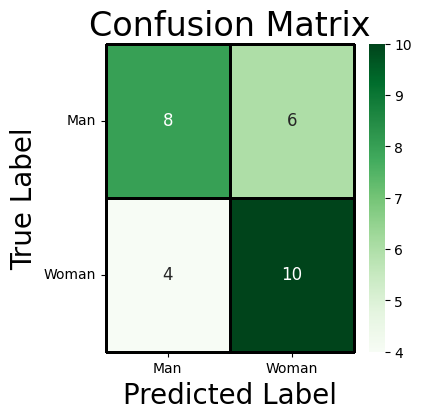

In [65]:
#CNN CONFUSION MATRIX
class_names = ['Man','Woman']

plot_confusion_matrix(
    test_df.label_encoded,
    cnn_test_predictions,
    figsize=(4,4),
    classes=class_names
)

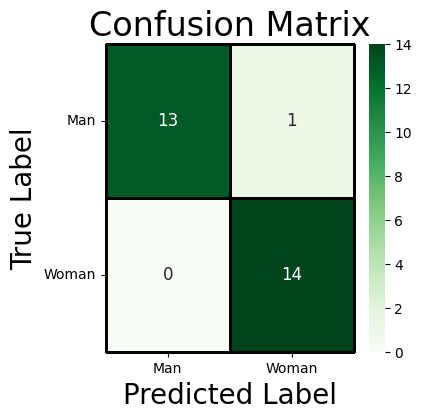

In [66]:
# EFFICIENTNET V2 B0 CONFUSION MATRIX
plot_confusion_matrix(
    test_df.label_encoded,
    efficientnet_v2_test_predictions,
    figsize=(4, 4),
    classes=class_names
)

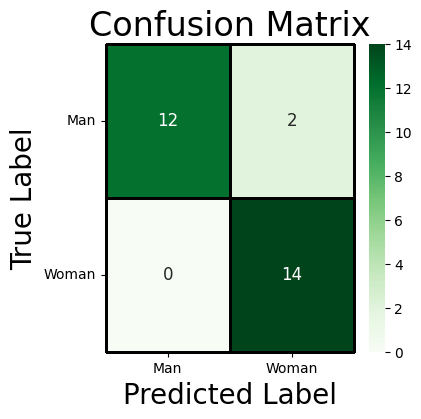

In [67]:
#VIT-B16 CONFUSION MATRIX
plot_confusion_matrix(
    test_df.label_encoded,
    vit_b16_test_predictions,
    figsize=(4, 4),
    classes=class_names
)

### Plot ROC curves
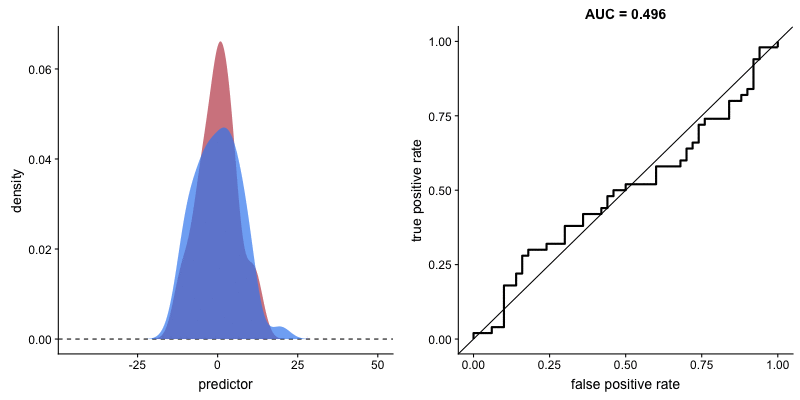
An ROC (Receiver Operating Characteristic) curve is a measure that illustrates the diagnostic ability of a classifier system as its discrimination threshold is varied. The curve is created by plotting the true positive rate (TPR) on the Y-axis against the false positive rate (FPR) on the X-axis at various classification thresholds. The area under the ROC curve (AUC) is calculated and used as a metric showing how well a model can classify data points.

TPR also links to Recall or Sensitivity, which is basically focused on the actual positives that should be labeled correctly, maximising the True Positives (even if that means misclassifying False Positives). Whereas Specificity is focused on making reducing the False Positives.

In [68]:
# in case old versions of packages are not compatible, we need to do this
# for instance scikitplot was trying to get a deprecated 'interp' module from scipy, now called interp1d
import scipy
if not hasattr(scipy, 'interp'):
    from scipy.interpolate import interp1d as interp
    scipy.interp = interp

In [69]:
pip install --upgrade scikit-plot

ValueError: x and y arrays must be equal in length along interpolation axis.

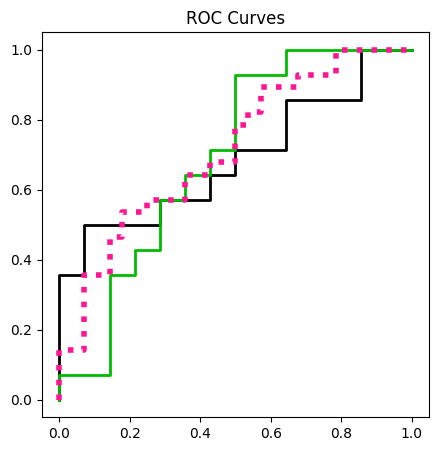

In [70]:
#CNN ROC CURVES
from scikitplot.metrics import plot_roc

plot_roc(test_df.label_encoded,
         cnn_test_probabilities,
         figsize=(5, 5), title_fontsize='large')
plt.title('ROC Curve for CNN')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.show()

ValueError: x and y arrays must be equal in length along interpolation axis.

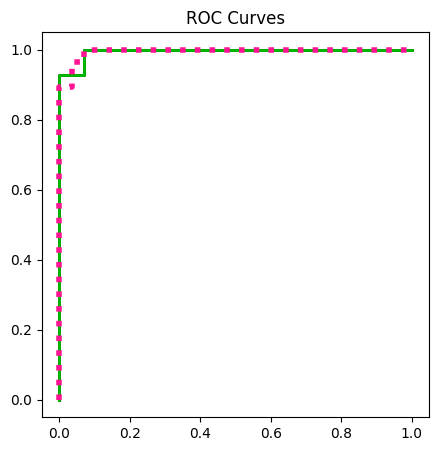

In [71]:
plot_roc(test_df.label_encoded,
         efficientnet_v2_test_probabilities,
         figsize=(5, 5), title_fontsize='large');

ValueError: x and y arrays must be equal in length along interpolation axis.

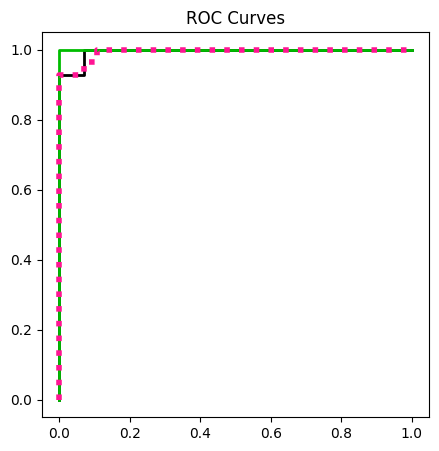

In [72]:
plot_roc(test_df.label_encoded,
         vit_b16_test_probabilities,
         figsize=(5, 5), title_fontsize='large');

### Classification reports

In [73]:
# VIEW CLASSIFICATION REPORTS

# CNN ROC Curves
print(classification_report(test_df.label_encoded,
                            cnn_test_predictions,
                            target_names=class_names))

              precision    recall  f1-score   support

         Man       0.67      0.57      0.62        14
       Woman       0.62      0.71      0.67        14

    accuracy                           0.64        28
   macro avg       0.65      0.64      0.64        28
weighted avg       0.65      0.64      0.64        28



In [74]:
# EfficientNet V2 ROC Curves
print(classification_report(test_df.label_encoded,
                            efficientnet_v2_test_predictions,
                            target_names=class_names))

              precision    recall  f1-score   support

         Man       1.00      0.93      0.96        14
       Woman       0.93      1.00      0.97        14

    accuracy                           0.96        28
   macro avg       0.97      0.96      0.96        28
weighted avg       0.97      0.96      0.96        28



In [75]:
# ViT-b16 ROC Curves
print(classification_report(test_df.label_encoded,
                            vit_b16_test_predictions,
                            target_names=class_names))

              precision    recall  f1-score   support

         Man       1.00      0.86      0.92        14
       Woman       0.88      1.00      0.93        14

    accuracy                           0.93        28
   macro avg       0.94      0.93      0.93        28
weighted avg       0.94      0.93      0.93        28



### Record classification metrics

In [76]:
def generate_performance_scores(y_true, y_pred, y_probabilities):
  model_accuracy = accuracy_score(y_true, y_pred)
  model_precision, model_recall, model_f1, _ = (
      precision_recall_fscore_support(
          y_true,
          y_pred,
          average='weighted'
      )
  )
  model_matthews_corrcoef = matthews_corrcoef(y_true, y_pred)

  print('=============================================')
  print(f'\nPerformance Metrics:\n')
  print('=============================================')
  print(f'accuracy_score:\t\t{model_accuracy:.4f}\n')
  print('_____________________________________________')
  print(f'precision_score:\t{model_precision:.4f}\n')
  print('_____________________________________________')
  print(f'recall_score:\t\t{model_recall:.4f}\n')
  print('_____________________________________________')
  print(f'f1_score:\t\t{model_f1:.4f}\n')
  print('_____________________________________________')
  print(f'matthews_corrcoef:\t{model_matthews_corrcoef:.4f}\n')
  print('=============================================')

  preformance_scores = {
      'accuracy_score': model_accuracy,
      'precision_score': model_precision,
      'recall_score': model_recall,
      'f1_score': model_f1,
      'matthews_corrcoef': model_matthews_corrcoef
  }
  return preformance_scores

In [77]:
# Generate CNN model performance scores
cnn_performance = generate_performance_scores(
    test_df.label_encoded,
    cnn_test_predictions,
    cnn_test_probabilities)


Performance Metrics:

accuracy_score:		0.6429

_____________________________________________
precision_score:	0.6458

_____________________________________________
recall_score:		0.6429

_____________________________________________
f1_score:		0.6410

_____________________________________________
matthews_corrcoef:	0.2887



In [78]:
# Generate EfficientNet model performances scores
efficientnet_v2_performance = generate_performance_scores(
    test_df.label_encoded,
    efficientnet_v2_test_predictions,
    efficientnet_v2_test_probabilities
)


Performance Metrics:

accuracy_score:		0.9643

_____________________________________________
precision_score:	0.9667

_____________________________________________
recall_score:		0.9643

_____________________________________________
f1_score:		0.9642

_____________________________________________
matthews_corrcoef:	0.9309



In [79]:
# Generate ViT model performances scores
vit_b16_performance = generate_performance_scores(
    test_df.label_encoded,
    vit_b16_test_predictions,
    vit_b16_test_probabilities
)


Performance Metrics:

accuracy_score:		0.9286

_____________________________________________
precision_score:	0.9375

_____________________________________________
recall_score:		0.9286

_____________________________________________
f1_score:		0.9282

_____________________________________________
matthews_corrcoef:	0.8660



In [80]:
# Record metrics with DataFrame
performance_df = pd.DataFrame({
    'model_cnn': cnn_performance,
    'model_efficientnet_v2': efficientnet_v2_performance,
    'model_vit_b16': vit_b16_performance
})

performance_df

,model_cnn,model_efficientnet_v2,model_vit_b16
accuracy_score,0.642857,0.964286,0.928571
precision_score,0.645833,0.966667,0.937500
recall_score,0.642857,0.964286,0.928571
f1_score,0.641026,0.964240,0.928205
matthews_corrcoef,0.288675,0.930949,0.866025


<b>Insight:</b> We observe that the EfficientNet model outperforms both the CNN and ViT model on all metrics, especially the Matthews Correlation Coefficient (MCC). A high MCC implies that the model's predictions are statistically of high quality and that the model does indeed generalise to unseen samples. The MCC takes into account all the confusion matrix ratios (TP, FP, TN, FN), so it's good for imbalanced datasets, and it's also very strict with the model failing to predict. That's why it's the most reliable metric, even over F1 score.

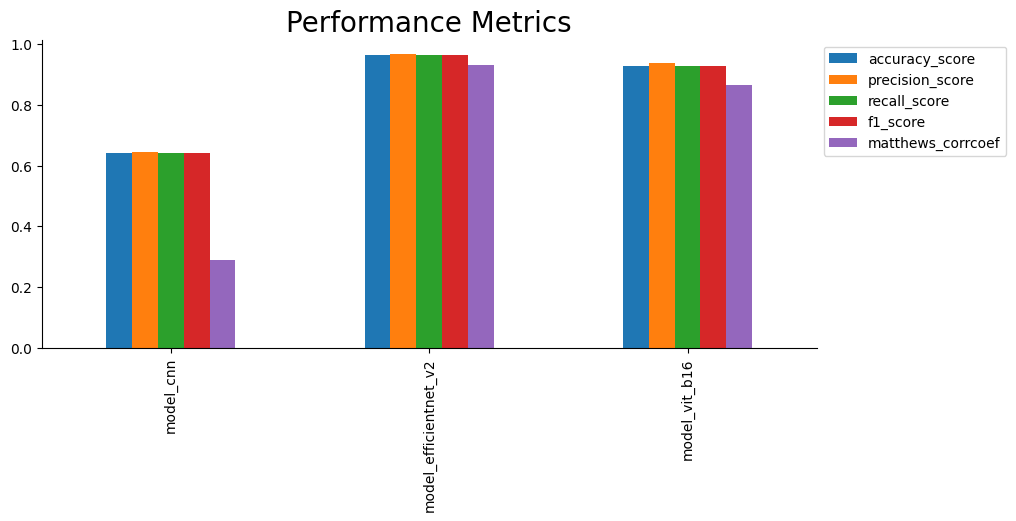

In [81]:
performance_df.T.plot(
    kind='bar',
    figsize=(10, 4)
).legend(bbox_to_anchor=(1.0, 1.0))

plt.title('Performance Metrics', fontsize=20);
sns.despine()

### Trade-offs: Inference Time vs Performance

In [82]:
def compute_inference_time(model, ds, sample_count, inference_runs=5):
    total_inference_times = []
    inference_rates = []

    for _ in range(inference_runs):
        start = time.perf_counter()
        model.predict(ds)
        end = time.perf_counter()

        # Compute total inference time
        total_inference_time = end - start

        # Compute inference rate
        inference_rate = total_inference_time / sample_count

        total_inference_times.append(total_inference_time)
        inference_rates.append(inference_rate)

    # Calculate average total inference time with uncertainty
    avg_inference_time = sum(total_inference_times) / len(total_inference_times)
    avg_inference_time_uncertainty = (max(total_inference_times) - min(total_inference_times)) / 2

    # Calculate average inference rate with uncertainty
    avg_inference_rate = sum(inference_rates) / len(inference_rates)
    avg_inference_rate_uncertainty = (max(inference_rates) - min(inference_rates)) / 2

    print('====================================================')
    print(f'Model:\t\t{model.name}\n')
    print(f'Inference Time:\t{round(avg_inference_time, 6)}s \xB1 {round(avg_inference_time_uncertainty, 6)}s')
    print(f'Inference Rate:\t{round(avg_inference_rate, 6)}s/sample \xB1 {round(avg_inference_rate_uncertainty, 6)}s/sample')
    print('====================================================')

    return avg_inference_time, avg_inference_rate

In [83]:
cnn_inference = compute_inference_time(model_cnn, test_ds, len(test_df))

1/1 [==============================] - 1s 951ms/step
Model:		cnn_sequential_model

Inference Time:	1.255799s ± 0.611708s
Inference Rate:	0.04485s/sample ± 0.021847s/sample


In [84]:
efficientnet_v2_inference = compute_inference_time(model_efficientnet_v2, test_ds, len(test_df))

1/1 [==============================] - 2s 2s/step
Model:		efficientnet_v2_sequential_model

Inference Time:	2.367953s ± 0.635896s
Inference Rate:	0.08457s/sample ± 0.022711s/sample


In [85]:
vit_b16_inference = compute_inference_time(model_vit_b16, test_ds, len(test_df))

1/1 [==============================] - 23s 23s/step
Model:		vit_b16_sequential_model

Inference Time:	40.998747s ± 0.04645s
Inference Rate:	1.464241s/sample ± 0.001659s/sample


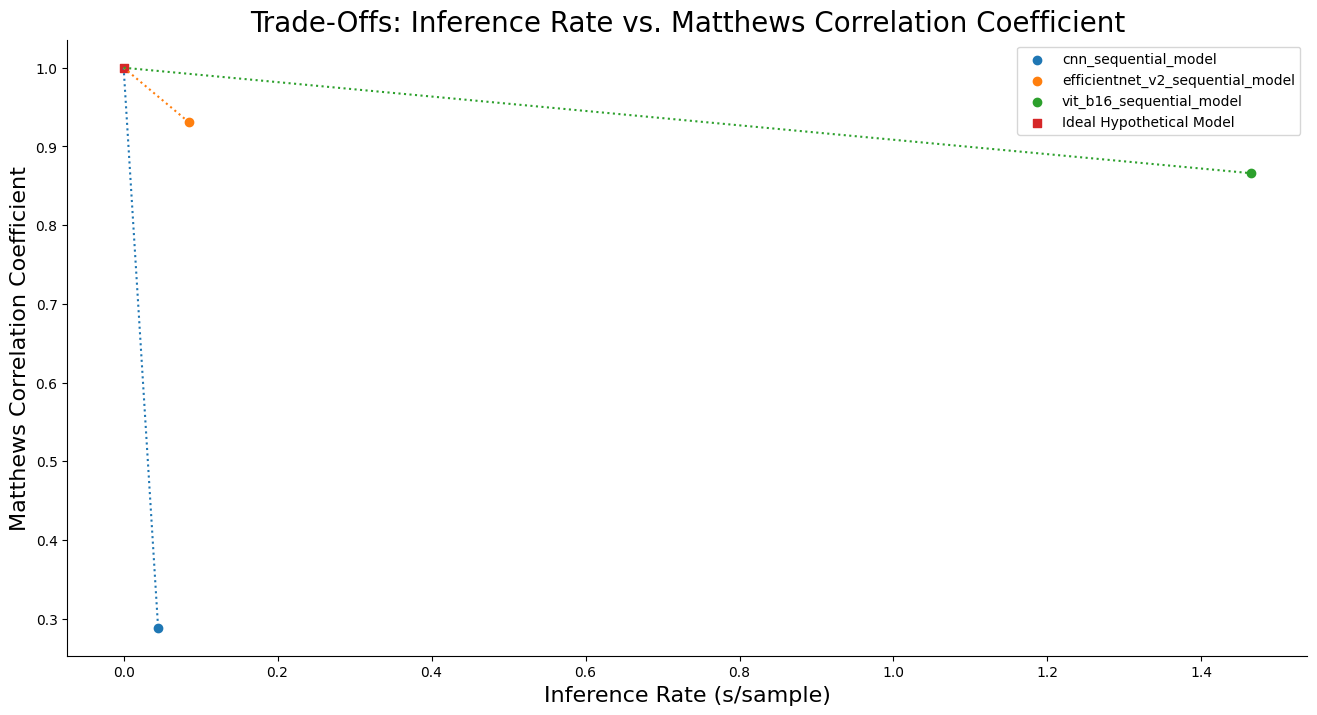

In [86]:
# Get MCC for each model
cnn_mcc = cnn_performance["matthews_corrcoef"]
efficientnet_mcc = efficientnet_v2_performance["matthews_corrcoef"]
vit_mcc = vit_b16_performance["matthews_corrcoef"]

# Scatter plot inference rate against MCC
plt.figure(figsize=(16, 8))

plt.scatter(cnn_inference[1], cnn_mcc, label=model_cnn.name)
plt.scatter(efficientnet_v2_inference[1], efficientnet_mcc, label=model_efficientnet_v2.name)
plt.scatter(vit_b16_inference[1], vit_mcc, label=model_vit_b16.name)

ideal_inference_rate = 0.0001 # Desired inference time (Exaggerated)
ideal_mcc = 1 # Max MCC

# Plot lines connecting each model coords. to the ideal model coords.
plt.scatter(ideal_inference_rate, ideal_mcc, label="Ideal Hypothetical Model", marker='s')
plt.plot([ideal_inference_rate, cnn_inference[1]], [ideal_mcc, cnn_mcc], ':')
plt.plot([ideal_inference_rate, efficientnet_v2_inference[1]], [ideal_mcc, efficientnet_mcc], ':')
plt.plot([ideal_inference_rate, vit_b16_inference[1]], [ideal_mcc, vit_mcc], ':')

plt.legend()
plt.title("Trade-Offs: Inference Rate vs. Matthews Correlation Coefficient", fontsize=20)
plt.xlabel("Inference Rate (s/sample)", fontsize=16)
plt.ylabel("Matthews Correlation Coefficient", fontsize=16);

sns.despine();

In [87]:
def dist(x1, x2, y1, y2):
    return np.sqrt(np.square(x2 - x1) + np.square(y2 - y1))

model_names = [model_cnn.name, model_efficientnet_v2.name, model_vit_b16.name]
model_scores = [cnn_mcc, efficientnet_mcc, vit_mcc]
model_rates = [cnn_inference[1], efficientnet_v2_inference[1], vit_b16_inference[1]]
trade_offs = [dist(ideal_inference_rate, inference_rate, ideal_mcc, score)
              for inference_rate, score in zip(model_rates, model_scores)]

print('Trade-Off Score: Inference Rate vs. MCC')
for name, inference_rate, score, trade in zip(model_names, model_rates, model_scores, trade_offs):
    print('---------------------------------------------------------')
    print(f'Model: {name}\n\nInference Rate: {inference_rate:.5f} | MCC: {score:.4f} | Trade-Off: {trade:.4f}')

# View model with best trade-off score
print('=========================================================')
best_model_trade = min(trade_offs)
best_model_name = model_names[np.argmin(trade_offs)]
print(f'\nBest Optimal Model:\t{best_model_name}\nTrade-Off:\t\t{best_model_trade:.4f}\n')
print('=========================================================')

Trade-Off Score: Inference Rate vs. MCC
---------------------------------------------------------
Model: cnn_sequential_model

Inference Rate: 0.04485 | MCC: 0.2887 | Trade-Off: 0.7127
---------------------------------------------------------
Model: efficientnet_v2_sequential_model

Inference Rate: 0.08457 | MCC: 0.9309 | Trade-Off: 0.1091
---------------------------------------------------------
Model: vit_b16_sequential_model

Inference Rate: 1.46424 | MCC: 0.8660 | Trade-Off: 1.4703

Best Optimal Model:	efficientnet_v2_sequential_model
Trade-Off:		0.1091



### View test predictions

In [88]:
test_df

,image_path,label,label_encoded
0,/content/drive/My Drive/Wounds CV/Practice/Man...,Woman,1
1,/content/drive/My Drive/Wounds CV/Practice/Man...,Man,0
2,/content/drive/My Drive/Wounds CV/Practice/Man...,Woman,1
3,/content/drive/My Drive/Wounds CV/Practice/Man...,Man,0
4,/content/drive/My Drive/Wounds CV/Practice/Man...,Woman,1
5,/content/drive/My Drive/Wounds CV/Practice/Man...,Woman,1
6,/content/drive/My Drive/Wounds CV/Practice/Man...,Man,0
7,/content/drive/My Drive/Wounds CV/Practice/Man...,Man,0
8,/content/drive/My Drive/Wounds CV/Practice/Man...,Woman,1
9,/content/drive/My Drive/Wounds CV/Practice/Man...,Woman,1


In [93]:
def view_multiple_predictions(df, model, sample_loader, count=10, color_map='rgb', title=None, fig_size=(14, 10)):
    rows = count//5
    if count%5 > 0:
        rows +=1

    idx = random.sample(df.index.to_list(), count)

    fig = plt.figure(figsize=fig_size)
    if title != None:
        fig.suptitle(title, fontsize=30)

    fig.tight_layout()
    fig.subplots_adjust(top=0.95)

    # Setup useful dictionaries
    label_set = {0: 'Man', 1: 'Woman'}
    color_set = {False: 'red', True: 'darkgreen'}

    for column, _ in enumerate(idx):
        # Predict label
        img = sample_loader(df.image_path[_])
        probability = np.squeeze(
            model.predict(np.array([img]), verbose=0)
        )
        prediction = np.argmax(probability)

        # Validate prediction correctness
        correct_prediction = (prediction == df.label_encoded[_])

        # Create subplot and assign title
        ax = plt.subplot(rows, 5, column+1)
        ax.set_title(
            f'Actual Label: {df.label[_]}',
            pad=20,
            fontsize=14,
            color=color_set[correct_prediction]
        )

        # Plot image
        if color_map=='rgb':
            ax.imshow(img)
        else:
            ax.imshow(tf.image.rgb_to_grayscale(img), cmap=color_map)

        # Plot prediction  & probability
        txt = f'Prediction: {label_set[prediction]}\nProbability: {(100 * probability[prediction]):.2f}%'
        plt.xlabel(txt, fontsize=14, color=color_set[correct_prediction])

    return

In [95]:
# View CNN predictions
view_multiple_predictions(
    test_df,
    model_efficientnet_v2,
    _load,
    count=25,
    color_map='rgb',
    title='CNN Test Predictions',
    fig_size=(20, 28)
)

Output hidden; open in https://colab.research.google.com to view.

### Conclusion
The models explored in this notebook still have room for improvement. The following should be considered:


- <b>Increasing the width and depth of the classification head </b>: Using more dense layers along with more units may result in improved performance, but may also hinder the inference rate.

- <b>Using Fine-Tuning techniques</b>: Fine-Tuning was not applied in this notebook to prevent adding to the complexity of the notebook. Applying fine-tuning methods may result in improved performance whilst maintaining similar inference rates. Note that this may require more computational resources and in the case of the Vision Transformer - lots of DATA as well!

- <b>Using Ensembling methods</b>: Ensembling is a powerful technique which allows for the pooling of knowledge from various models all trained to solve the same problem (much like transfer learning). Improved results may be achived through ensembling techniques (such as blending, stacking or voting) at the expense of higher a inference rate.